In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [2]:
train = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv")
sub = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")

In [3]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [5]:
train.shape

(70128, 6)

In [6]:
table2 = pd.DataFrame(train.groupby(["product"])["num_sold"].sum())
table2.style.background_gradient(cmap="turbo")

,num_sold
product,
Kaggle Advanced Techniques,3913910
Kaggle Getting Started,3136903
Kaggle Recipe Book,2349817
Kaggle for Kids: One Smart Goose,4225029


In [7]:
table3 = pd.DataFrame(train.groupby(["country"])["num_sold"].sum())
table3.style.background_gradient(cmap="prism")

,num_sold
country,
Belgium,2781050
France,2512319
Germany,2786415
Italy,2201092
Poland,1341545
Spain,2003238


In [8]:
table_2 = pd.DataFrame(train.nunique())
table_2.style.background_gradient(cmap="Reds")

,0
row_id,70128
date,1461
country,6
store,2
product,4
num_sold,699


In [9]:
fig = px.pie(train, names='product', title='product Pie Chart')
fig.show()

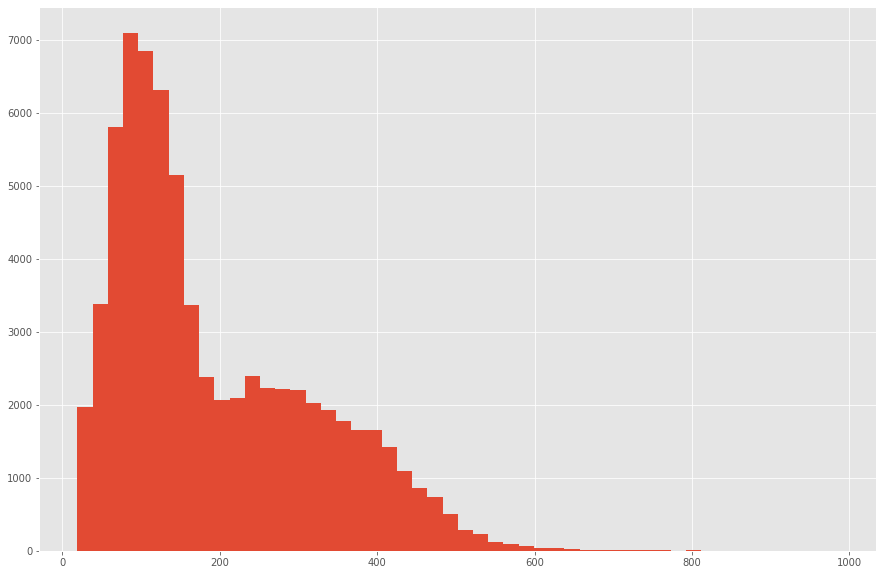

In [10]:
plt.figure(figsize=(15,10))
plt.style.use("ggplot")
train["num_sold"].hist(bins = 50)
plt.show()

In [11]:
all_data = pd.concat([train, test], axis =0)
all_data.shape

(87648, 6)

In [12]:
all_data['date'] = pd.to_datetime((all_data['date']))
all_data['year'] = all_data['date'].dt.year
all_data['month'] = all_data['date'].dt.month
all_data['dayOfMonth'] = all_data['date'].dt.day
all_data['dayOfYear'] = all_data['date'].dt.dayofyear
all_data['weekday'] = all_data['date'].dt.weekday

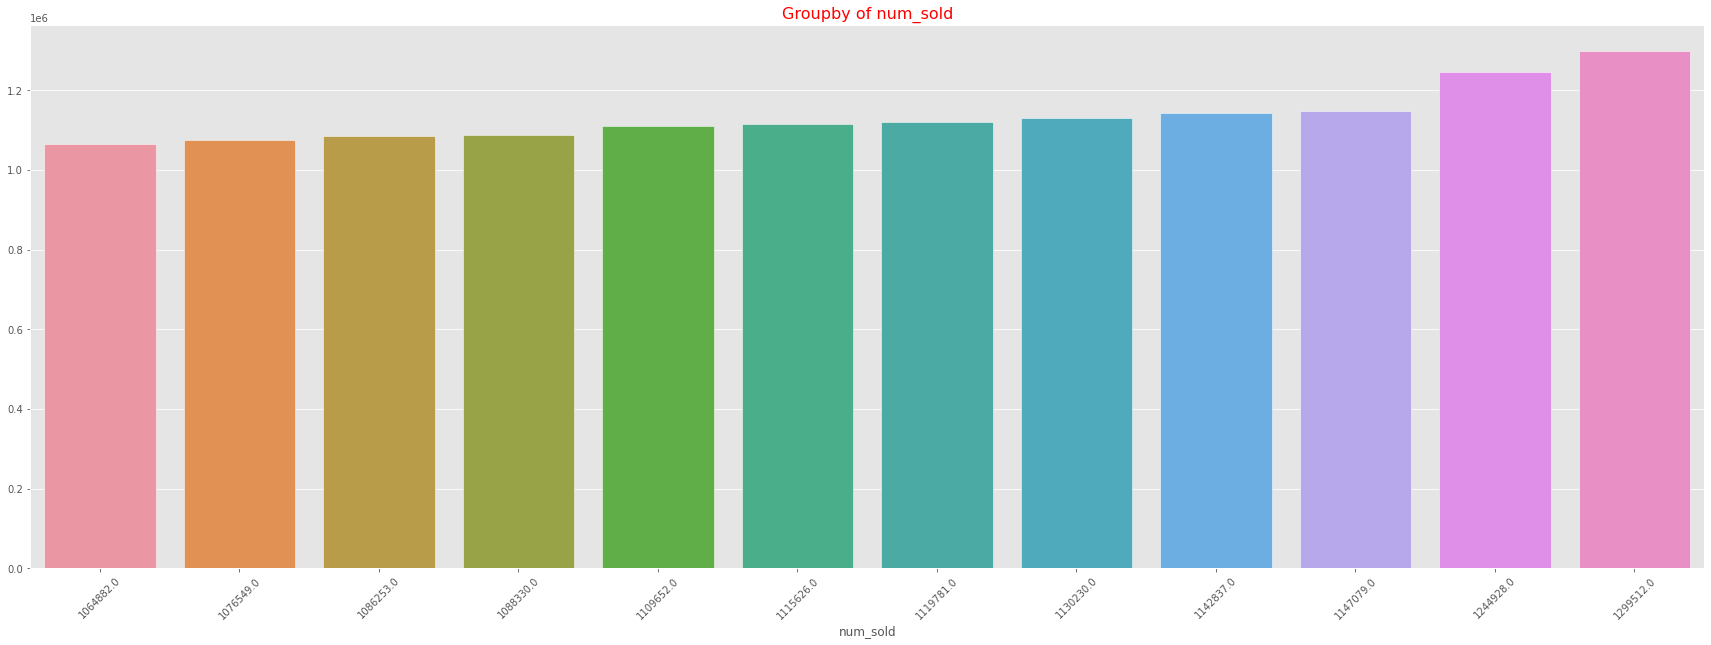

In [13]:
table4 = all_data.groupby("month")["num_sold"].sum()
plt.figure(figsize=(30,10))
plt.title("Groupby of num_sold", size = 16, color = "red")
sns.set_style("darkgrid")
sns.barplot(x =table4.index, y =table4.values, data = table4)
plt.xticks(rotation=45)
plt.show()

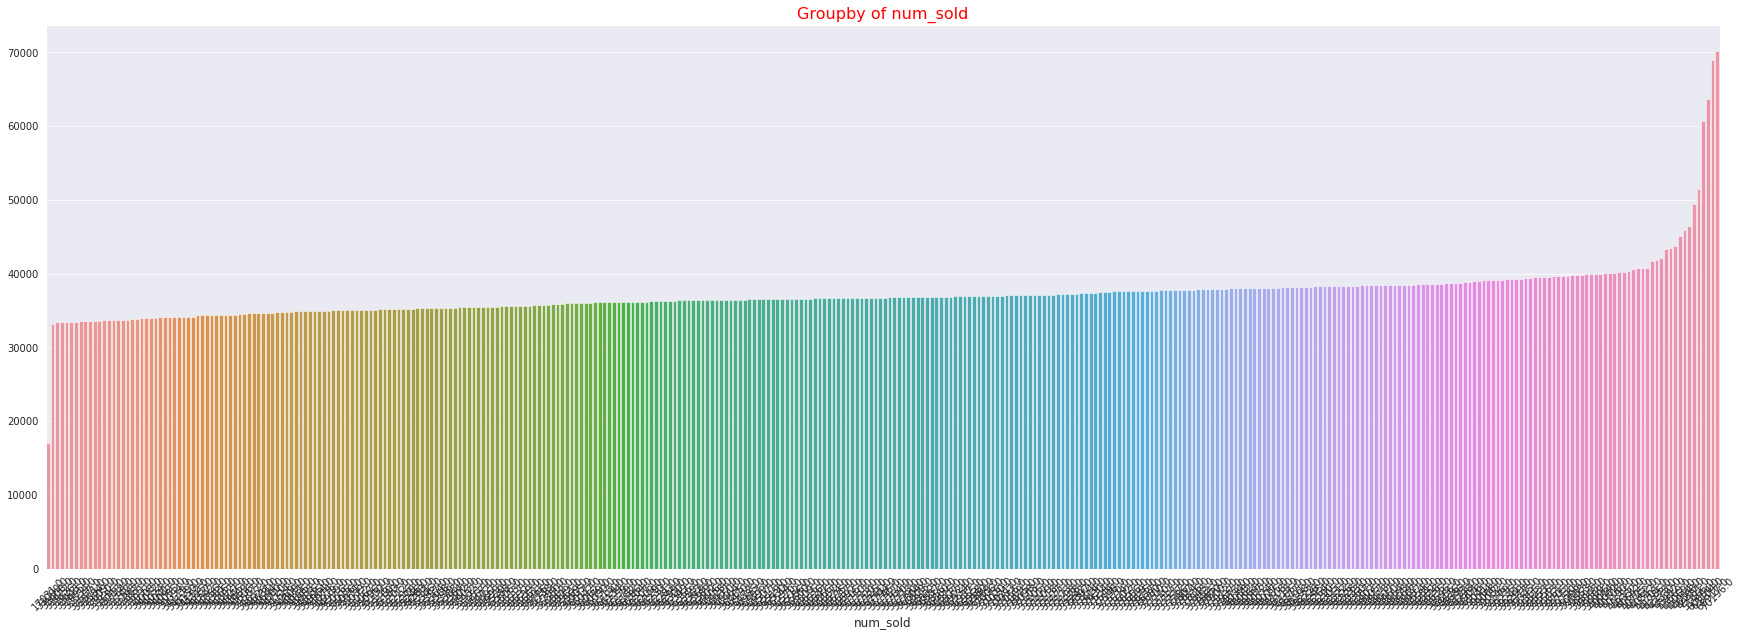

In [14]:
table4 = all_data.groupby("dayOfYear")["num_sold"].sum()
plt.figure(figsize=(30,10))
plt.title("Groupby of num_sold", size = 16, color = "red")
sns.set_style("darkgrid")
sns.barplot(x =table4.index, y =table4.values, data = table4)
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

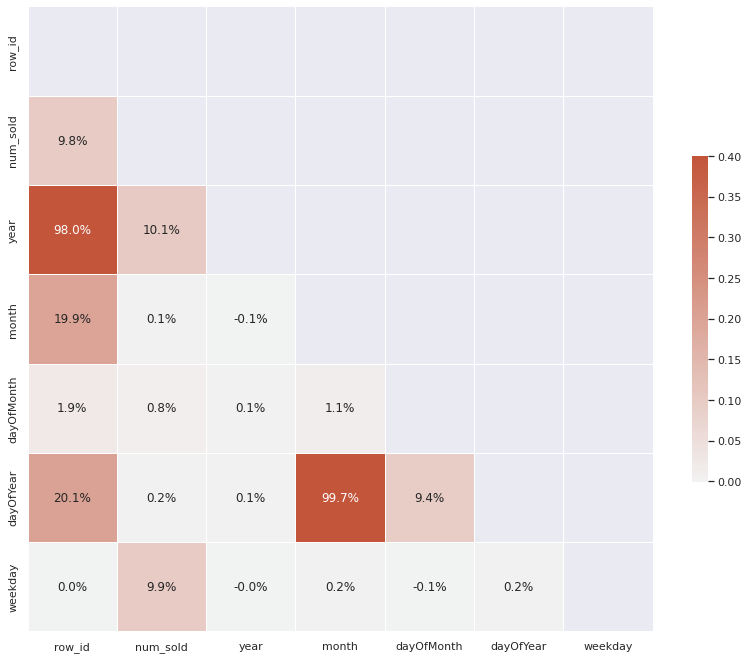

In [15]:
corr = all_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set(style="dark")
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}, annot=True ,fmt='.1%')

In [16]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le = LabelEncoder()
cols = ['country', 'store', 'product']
for col in cols:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col])
    

In [19]:
all_data = all_data.drop(["date","row_id"], axis = 1)
train = all_data.iloc[:70128,:]
test = all_data.iloc[70128:,:].drop(["num_sold"], axis = 1)

In [20]:
X = train.drop(["num_sold"], axis = 1)
y = train["num_sold"]

y_ = np.log(train["num_sold"])
y_.value_counts()

4.394449    404
4.488636    402
4.605170    402
4.442651    402
4.682131    392
           ... 
6.599870      1
6.760415      1
6.777647      1
6.368187      1
6.519147      1
Name: num_sold, Length: 699, dtype: int64

In [21]:
t1=time.time()
kf = KFold(n_splits=4, shuffle=True, random_state = 34)
off = np.zeros(len(train))
score_list_lgb = []
test_preds_lgb = []
fold = 1

for train_index, test_index in kf.split(X,y_):
    
    #ilgili iloclara göre split edilmesi
    X_train , X_val = X.iloc[train_index], X.iloc[test_index]  
    y_train, y_val =y_.iloc[train_index], y_.iloc[test_index]    
    
    print("X_train shape is :", X_train.shape,"X_val shape is", X_val.shape)
    y_pred_list = []
    
    model_lgb = LGBMRegressor(n_estimators= 3000, 
                               learning_rate= 0.059,
                               num_leaves= 37,
                               max_depth= 9, 
                               lambda_l1 = 3.69, 
                               lambda_l2 = 1.0152938, 
                               bagging_fraction= 0.95, 
                               feature_fraction= 0.96)

    model = model_lgb.fit(X_train,y_train)
    result = model_lgb.predict(X_val)
    
    result = pd.DataFrame(result)
    result.iloc[:,0] = [0 if i <= 0 else i for i in result.iloc[:,0]]
    
    score= np.sqrt(mean_squared_error(y_val, result))
    print("Fold",str(fold),"Result is:",score,"\n")
    score_list_lgb.append(score)

    test_preds_lgb.append(model_lgb.predict(test))
    fold +=1

t2 = time.time()
print("LGBM model with cross validation take : {:.3f} sn.".format(t2-t1))

X_train shape is : (52596, 8) X_val shape is (17532, 8)
[LightGBM] [Warning] lambda_l1 is set=3.69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.69
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] lambda_l2 is set=1.0152938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0152938
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
Fold 1 Result is: 0.057324788304394594 

X_train shape is : (52596, 8) X_val shape is (17532, 8)
[LightGBM] [Warning] lambda_l1 is set=3.69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.69
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] lambda_l2 is set=1.0152938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0152938
[LightGBM] [Warning] bagging_fract

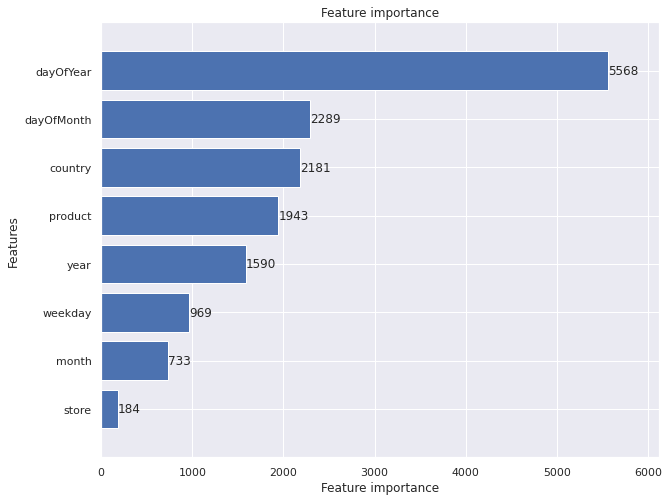

In [22]:
plt.rcParams["figure.figsize"] = (10,8)
lgbm.plot_importance(model_lgb, max_num_features = 10, height=0.8)
plt.show()

In [23]:
mean = sum(score_list_lgb) / len(score_list_lgb)
variance = sum([((x - mean) ** 2) for x in score_list_lgb]) / len(score_list_lgb)
res = variance ** 0.5
print("Cross validation mean score:", sum(score_list_lgb) / len(score_list_lgb))
print("Cross validation score's Standart deviation is:", res)

test_preds_lgb = pd.DataFrame(test_preds_lgb)
print(test_preds_lgb.shape)

test_preds_lgb = test_preds_lgb.mean(axis=0)
print(test_preds_lgb.head(5))

Cross validation mean score: 0.0575444230113806
Cross validation score's Standart deviation is: 0.0003556153920657916
(4, 17520)
0    6.169887
1    5.872002
2    5.711264
3    6.205961
4    5.109916
dtype: float64


In [24]:
sub["num_sold"] = np.exp(test_preds_lgb)
sub.to_csv("submission2.csv", index = False)
sub.head()

,row_id,num_sold
0,70128,478.132023
1,70129,354.958987
2,70130,302.252730
3,70131,495.694964
4,70132,165.656462


## SHAP FOR UNDERSTANDING MODEL

In [25]:
X_val

,country,store,product,year,month,dayOfMonth,dayOfYear,weekday
3,0,0,3,2017,1,1,1,6
10,1,0,2,2017,1,1,1,6
12,1,1,0,2017,1,1,1,6
15,1,1,3,2017,1,1,1,6
18,2,0,2,2017,1,1,1,6
...,...,...,...,...,...,...,...,...
70114,4,0,2,2020,12,31,366,3
70116,4,1,0,2020,12,31,366,3
70124,5,1,0,2020,12,31,366,3
70125,5,1,1,2020,12,31,366,3


<span style="color:crimson; font-size:35px;">   SHAP </span>

## SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

* For documentation: https://shap.readthedocs.io/en/latest/index.html

In [26]:
import shap
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_val)

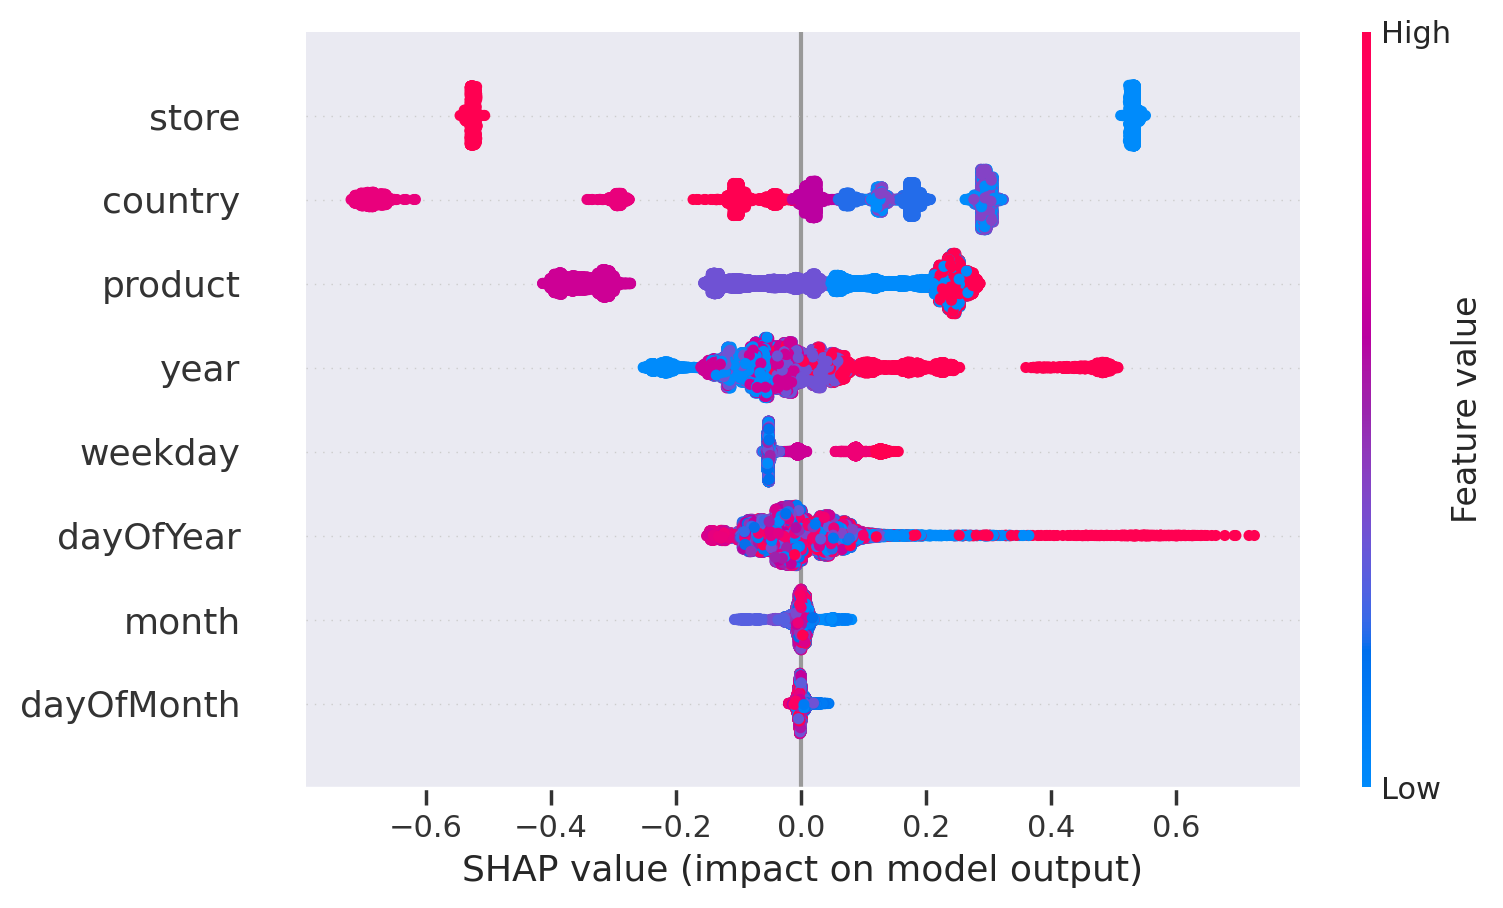

In [27]:
fig = plt.subplots(figsize=(4,4),dpi=200)
X = pd.DataFrame(train.drop("num_sold", axis = 1))
shap.summary_plot(shap_values, X_val,plot_type="dot")

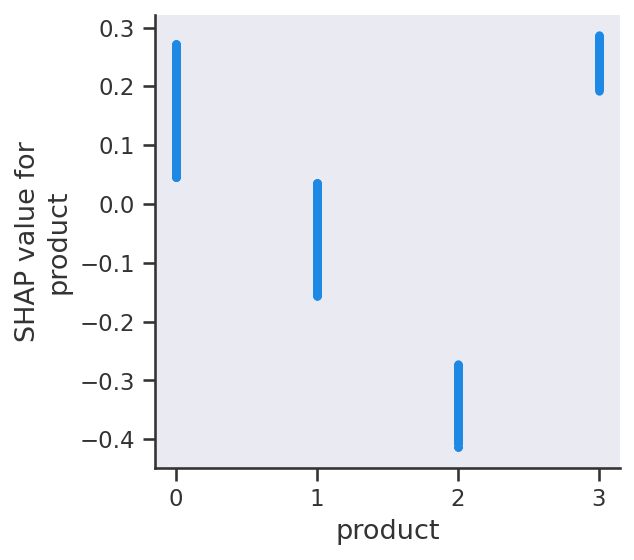

In [28]:
fig, ax1= plt.subplots(figsize=(4,4),dpi=150)

shp_plt = shap.dependence_plot("product", shap_values,X_val,ax=ax1, interaction_index=None)

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:50], X_train.iloc[:50],link= "logit")

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[35], X_train.iloc[[35]], link= "logit")